## Preprocessing

In [1]:
#[1]*10**10

In [2]:
!pip install ipython-autotime
%load_ext autotime

time: 129 µs (started: 2021-11-11 19:09:30 +00:00)


In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive
time: 3min 8s (started: 2021-11-11 19:09:30 +00:00)


In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications import NASNetLarge

time: 2.52 s (started: 2021-11-11 19:12:38 +00:00)


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

time: 503 ms (started: 2021-11-11 19:12:40 +00:00)


In [7]:
import os
path = "/content/gdrive/MyDrive/CVA2 600x600"
os.chdir(path)

time: 2.42 ms (started: 2021-11-11 19:12:41 +00:00)


In [8]:
TARGET_HEIGHT = 600
TARGET_WIDTH = 600
BATCH_SIZE = 16
VALIDATION_SPLIT= 0.2
EPOCHS = 20
NORMALIZE = False
num_classes = 75

time: 1.73 ms (started: 2021-11-11 19:12:41 +00:00)


In [11]:
#valid_dataset = create_dataset(train_folder,subset='validation',BATCH_SIZE=BATCH_SIZE,TARGET_HEIGHT=TARGET_HEIGHT,TARGET_WIDTH=TARGET_WIDTH,validation_split=VALIDATION_SPLIT)

time: 666 µs (started: 2021-11-11 19:12:41 +00:00)


In [12]:
import random
train_folder = 'train'
def generate_data_df_with_folds(kfold=10):
    files = pd.DataFrame()

    tmp = []
    labels_1 = []
    for i in range(75):
        for x,_,z in os.walk(train_folder+'/'+str(i)):
            for file in z:
                if 'desktop.ini' not in file:
                    filepath = x+'/'+file
                    tmp.append(filepath)
                    labels_1.append(i)

    labels_2 = [1 if i in range(15,74) else 0 for i in labels_1] #1 if food, 0 if place
    files['filepaths'] = pd.Series(tmp)
    files['target'] = pd.Series(labels_1)

    folds = []
    for i in range(75):
        n = files[files['target']==i].shape[0]
        tmp = []
        for fold in range(kfold):
            if fold != kfold-1:
                tmp += [fold]*(n//kfold)
            else:
                tmp+= [fold]*(n-len(tmp))
        random.shuffle(tmp)
        folds+=tmp
    files['fold'] = folds
    files['target'] = files['target'].astype(str)
    return files

files = generate_data_df_with_folds(kfold=5)

time: 56.5 s (started: 2021-11-11 19:12:41 +00:00)


Using the dataloader with the folds improved my Ram-usage on Colab-significantly, as with this size of dataset I was not able to run the model, due to its large RAM-usage, where Colab would continuously crash.

In [10]:
'''train_folder='train'
train_dataset = create_dataset(train_folder,
                               subset='training',
                               BATCH_SIZE=BATCH_SIZE,
                               TARGET_HEIGHT=TARGET_HEIGHT,
                               TARGET_WIDTH=TARGET_WIDTH,
                               validation_split=VALIDATION_SPLIT)
class_names = train_dataset.class_names
num_classes = len(class_names)'''

"train_folder='train'\ntrain_dataset = create_dataset(train_folder,\n                               subset='training',\n                               BATCH_SIZE=BATCH_SIZE,\n                               TARGET_HEIGHT=TARGET_HEIGHT,\n                               TARGET_WIDTH=TARGET_WIDTH,\n                               validation_split=VALIDATION_SPLIT)\nclass_names = train_dataset.class_names\nnum_classes = len(class_names)"

time: 2.57 ms (started: 2021-11-11 19:12:41 +00:00)


In [9]:
'''def create_dataset(folder,subset,BATCH_SIZE,TARGET_HEIGHT,TARGET_WIDTH,validation_split=0.2 ,seed=1234,label_mode='int'):    
    dataset = tf.keras.preprocessing.image_dataset_from_directory(folder,
                                                                  subset=subset,
                                                                  validation_split=validation_split,
                                                                  seed=seed,
                                                                  label_mode=label_mode,
                                                                  batch_size=BATCH_SIZE,
                                                                  image_size=(TARGET_HEIGHT,TARGET_WIDTH)
                                                                  )
    return dataset'''

"def create_dataset(folder,subset,BATCH_SIZE,TARGET_HEIGHT,TARGET_WIDTH,validation_split=0.2 ,seed=1234,label_mode='int'):    \n    dataset = tf.keras.preprocessing.image_dataset_from_directory(folder,\n                                                                  subset=subset,\n                                                                  validation_split=validation_split,\n                                                                  seed=seed,\n                                                                  label_mode=label_mode,\n                                                                  batch_size=BATCH_SIZE,\n                                                                  image_size=(TARGET_HEIGHT,TARGET_WIDTH)\n                                                                  )\n    return dataset"

time: 3.3 ms (started: 2021-11-11 19:12:41 +00:00)


In [13]:
preproc_func_effnet = tf.keras.applications.efficientnet.preprocess_input # pass through layer
preproc_func = preproc_func_effnet

train_dir = os.path.abspath("train")
gen = ImageDataGenerator(horizontal_flip = True,
                            vertical_flip=True,
                            rotation_range = 20,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
              validation_split=0.1, 
              fill_mode="nearest",
              preprocessing_function=preproc_func)

time: 3 ms (started: 2021-11-11 19:13:37 +00:00)


In [14]:
#gen = tf.keras.preprocessing.image.ImageDataGenerator()
train_dataset = gen.flow_from_dataframe(files[files['fold']>1],
                                        x_col='filepaths',
                                        y_col='target',
                                class_mode='sparse',batch_size=BATCH_SIZE,
                                target_size=(600,600))
valid_dataset = gen.flow_from_dataframe(files[files['fold']<=1],
                                        x_col='filepaths',
                                        y_col='target',
                                class_mode='sparse',batch_size=BATCH_SIZE,target_size=(600,600),shuffle=False)

Found 18691 validated image filenames belonging to 75 classes.
Found 12374 validated image filenames belonging to 75 classes.
time: 3.3 s (started: 2021-11-11 19:13:37 +00:00)


In [16]:
# AMEND DATA SUCH THAT IT IS LESS BIASED

time: 705 µs (started: 2021-11-11 19:13:41 +00:00)


## Image Preprocessing

In [20]:
'''AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(AUTOTUNE)
valid_dataset = valid_dataset.cache().prefetch(AUTOTUNE)'''

'AUTOTUNE = tf.data.experimental.AUTOTUNE\ntrain_dataset = train_dataset.cache().prefetch(AUTOTUNE)\nvalid_dataset = valid_dataset.cache().prefetch(AUTOTUNE)'

time: 3.25 ms (started: 2021-11-11 19:13:41 +00:00)


# Tensorflow Implementation & importing EffiecientNetB7

In [21]:
num_classes = 75
def create_model(TARGET_HEIGHT,TARGET_WIDTH):
    input_shape = (TARGET_HEIGHT,TARGET_WIDTH,3)
    model = EfficientNetB7(weights="imagenet", include_top=False, input_shape=(600, 600, 3), classes=75)
    
    for layer in model.layers:
        layer.trainable = False

    flat_layer = layers.GlobalAveragePooling2D()(model.layers[-1].output)
    drop_layer = layers.Dropout(0.5)(flat_layer)     
    class_layer = layers.Dense(1024,activation='relu')(drop_layer)
    
    output = layers.Dense(num_classes, activation='softmax',name='Classification')(class_layer)
    model= Model(inputs=model.inputs,outputs=output)
    model.summary()
    return model

time: 7.06 ms (started: 2021-11-11 19:13:41 +00:00)


In [22]:
model = create_model(TARGET_HEIGHT=TARGET_HEIGHT,TARGET_WIDTH=TARGET_WIDTH)

258088960/258076736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 600, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 600, 600, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 600, 600, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding

In [23]:
'''def compile_model(model):
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        optimizer=optimizers.Adam(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()])
    print("Model has been compiled!")'''

'def compile_model(model):\n    model.compile(\n        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),\n        optimizer=optimizers.Adam(),\n        metrics=[tf.keras.metrics.CategoricalAccuracy()])\n    print("Model has been compiled!")'

time: 4.54 ms (started: 2021-11-11 19:13:51 +00:00)


In [24]:
def compile_model(model):
    model.compile(
      optimizer = tf.keras.optimizers.SGD(learning_rate=0.008, momentum=0.9), 
      loss = 'sparse_categorical_crossentropy', 
      metrics=[
      'accuracy',
      tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top_5_accuracy", dtype=None)
      ]
)
#optimizers.Adam(),    

time: 2.45 ms (started: 2021-11-11 19:13:51 +00:00)


In [25]:
compile_model(model)

time: 28.3 ms (started: 2021-11-11 19:13:51 +00:00)


In [26]:
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

time: 1.41 ms (started: 2021-11-11 19:13:51 +00:00)


In [27]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="Checkpoint",monitor="val_loss")


time: 821 µs (started: 2021-11-11 19:13:51 +00:00)


In [28]:
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

    '''def on_test_begin(self, logs=None):
        #keys = list(logs.keys())
        #print("Start testing; got log keys: {}".format(keys))

    #def on_test_end(self, logs=None):
        #keys = list(logs.keys())
        #print("Stop testing; got log keys: {}".format(keys))

    #def on_predict_begin(self, logs=None):
        #keys = list(logs.keys())
        #print("Start predicting; got log keys: {}".format(keys))'''

time: 9.18 ms (started: 2021-11-11 19:13:51 +00:00)


In [29]:
print(num_classes)

75
time: 595 µs (started: 2021-11-11 19:13:51 +00:00)


In [30]:
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=[CustomCallback()])

Starting training; got log keys: []
Start epoch 0 of training; got log keys: []
Epoch 1/20
1169/1169 [==============================] - 14281s 12s/step - loss: 1.4360 - accuracy: 0.6159 - top_5_accuracy: 0.8744 - val_loss: 0.7639 - val_accuracy: 0.7725 - val_top_5_accuracy: 0.9643
Start epoch 1 of training; got log keys: []
Epoch 2/20
1169/1169 [==============================] - 784s 670ms/step - loss: 0.7375 - accuracy: 0.7736 - top_5_accuracy: 0.9683 - val_loss: 0.6421 - val_accuracy: 0.7984 - val_top_5_accuracy: 0.9758
Start epoch 2 of training; got log keys: []
Epoch 3/20
1169/1169 [==============================] - 783s 670ms/step - loss: 0.5872 - accuracy: 0.8171 - top_5_accuracy: 0.9811 - val_loss: 0.5462 - val_accuracy: 0.8248 - val_top_5_accuracy: 0.9800
Start epoch 3 of training; got log keys: []
Epoch 4/20
1169/1169 [==============================] - 784s 670ms/step - loss: 0.5158 - accuracy: 0.8358 - top_5_accuracy: 0.9843 - val_loss: 0.4693 - val_accuracy: 0.8555 - val_top

In [32]:
model.save('/models/test/')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


time: 1min 56s (started: 2021-11-12 03:20:08 +00:00)


In [33]:
#from keras.models import load_model
#model = tf.keras.models.load_model('/models/test/')

time: 649 µs (started: 2021-11-12 03:22:04 +00:00)


### Unfreezing the last 20 layers and re-running the model with the layers 

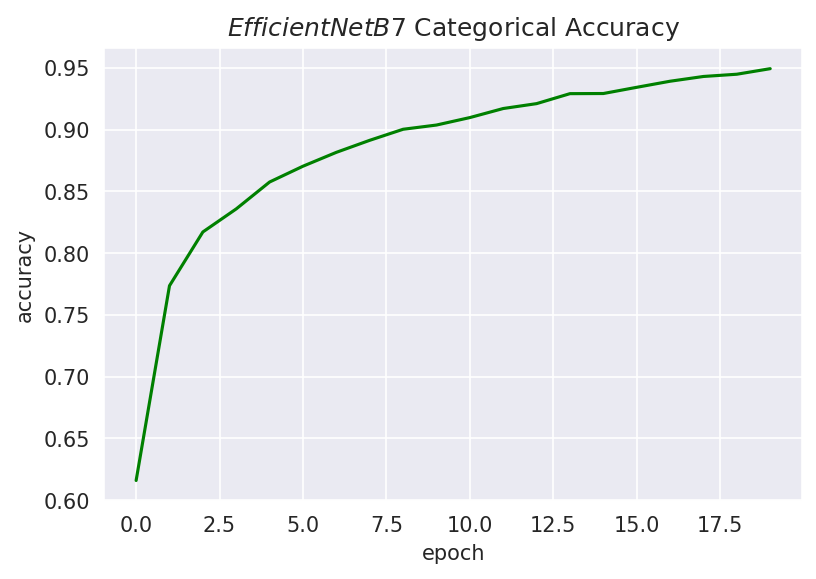

time: 847 ms (started: 2021-11-12 03:26:10 +00:00)


In [39]:
# Summarizing the history for Accuracy
metric = 'accuracy'

plt.figure(dpi=150)
plt.plot(history.history[metric], 'g')
plt.title(f'$EfficientNetB7$ Categorical Accuracy')

plt.ylabel(metric)
plt.xlabel('epoch')
if not os.path.exists('charts'):
    os.makedirs('charts')

plt.savefig(f"charts/Categorical Accuracy.jpeg")
plt.show()

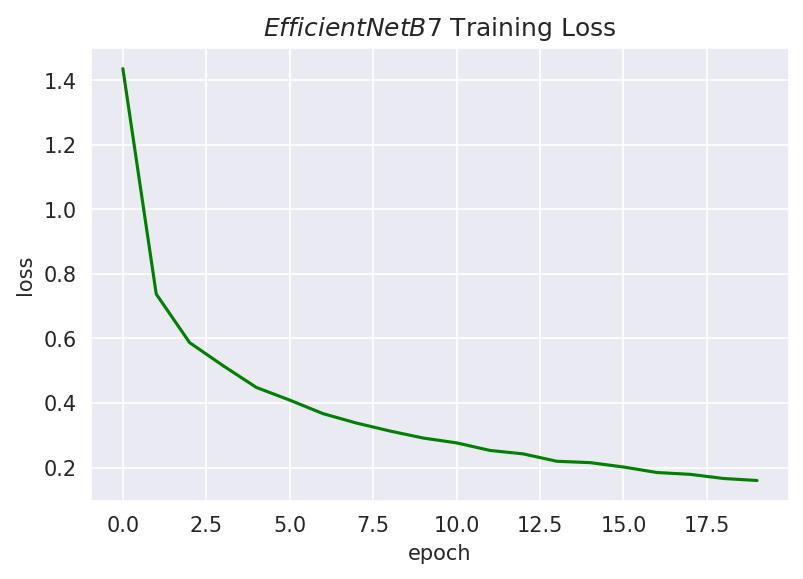

time: 1.13 s (started: 2021-11-12 03:26:09 +00:00)


In [38]:
# Summarizing the history for Loss

plt.figure(dpi=150)
plt.plot(history.history['loss'], 'g')
plt.title('$EfficientNetB7$ Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
if not os.path.exists('charts'):
    os.makedirs('charts')

plt.savefig("charts/history_loss.jpeg")
plt.show()

In [ ]:
## Export before Fine-Tuning

In [ ]:
from tensorflow.python.data.ops import dataset_ops
from tensorflow.python.keras.layers.preprocessing import image_preprocessing
from tensorflow.python.keras.preprocessing import dataset_utils
from tensorflow.python.ops import image_ops
from tensorflow.python.ops import io_ops
from tensorflow.python.util.tf_export import keras_export

In [133]:
## Import Test-Folder and predict each values:
directory = 'test'

test_set = tf.keras.utils.image_dataset_from_directory('test',
                                                   labels=None,image_size=(600,600),shuffle=False)

for x in test_set.file_paths:
    print(x)

import pandas as pd
df = pd.DataFrame([int(x.replace('test/','').replace('.jpg','')) for x in test_set.file_paths])

Found 4315 files belonging to 1 classes.
test/test/1.jpg
test/test/10.jpg
test/test/100.jpg
test/test/1000.jpg
test/test/1001.jpg
test/test/1002.jpg
test/test/1003.jpg
test/test/1004.jpg
test/test/1005.jpg
test/test/1006.jpg
test/test/1007.jpg
test/test/1008.jpg
test/test/1009.jpg
test/test/101.jpg
test/test/1010.jpg
test/test/1011.jpg
test/test/1012.jpg
test/test/1013.jpg
test/test/1014.jpg
test/test/1015.jpg
test/test/1016.jpg
test/test/1017.jpg
test/test/1018.jpg
test/test/1019.jpg
test/test/102.jpg
test/test/1020.jpg
test/test/1021.jpg
test/test/1022.jpg
test/test/1023.jpg
test/test/1024.jpg
test/test/1025.jpg
test/test/1026.jpg
test/test/1027.jpg
test/test/1028.jpg
test/test/1029.jpg
test/test/103.jpg
test/test/1030.jpg
test/test/1031.jpg
test/test/1032.jpg
test/test/1033.jpg
test/test/1034.jpg
test/test/1035.jpg
test/test/1036.jpg
test/test/1037.jpg
test/test/1038.jpg
test/test/1039.jpg
test/test/104.jpg
test/test/1040.jpg
test/test/1041.jpg
test/test/1042.jpg
test/test/1043.jpg


In [134]:
pred_test = model.predict(test_set)

test_df = pd.DataFrame()

test_df['Id'] = [int(x.replace('test/','').replace('.jpg','')) for x in test_set.file_paths]

import pandas as pd
mapper = pd.DataFrame()
mapper['range']=[str(x) for x in range(75)]
mapper.sort_values(by='range',inplace=True)
mapper.reset_index(drop=True,inplace=True)
mapper.reset_index(inplace=True)
mapping_dict = {k:int(v) for k,v in zip(mapper['index'],mapper['range'])}


output = [mapping_dict[x] for x in mapping_dict]

time: 1min 50s (started: 2021-11-12 08:44:03 +00:00)


In [135]:
#test_df = pd.DataFrame()
#test_df['Id'] = [int(x.replace('#directory of the test dataset','').replace('.jpg','')) for x in test_ds.file_paths]
top_5 = pred_test.argsort(axis=-1)[:,-5:]
test_df[[5-i for i in range(5)]] = top_5
for i in range(1,6):
  test_df[i] = [mapping_dict[x] for x in test_df[i]]
test_df.sort_values(by='Id',inplace=True)
test_df.reset_index(drop=True,inplace=True)
test_df
test_df = test_df[['Id',1,2,3,4,5]]
test_df.columns = ['Id','Top 1','Top 2','Top 3','Top 4','Top 5']
test_df['Top 5'] = test_df[test_df.columns[1:]].apply(lambda x: ','.join(x.astype(str)),axis=1)
test_df[['Id','Top 1','Top 5']].to_csv('submission_final1.csv',index=False)


def create_mapping():
    import pandas as pd
    mapper = pd.DataFrame()
    mapper['range']=[str(x) for x in range(75)]
    mapper.sort_values(by='range',inplace=True)
    mapper.reset_index(drop=True,inplace=True)
    mapper.reset_index(inplace=True)
    mapping_dict = {k:int(v) for k,v in zip(mapper['index'],mapper['range'])}
    return mapping_dict

mapping_dict = create_mapping()

time: 377 ms (started: 2021-11-12 08:45:53 +00:00)


In [113]:
def unfreeze_model(model):
    # We unfreeze the top 20-10-5 layers while leaving BatchNorm layers frozen
    
    for layer in model.layers[-5:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    #optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
    model.compile(
      optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
      loss = 'sparse_categorical_crossentropy', 
      metrics=[
      'accuracy',
      tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top_5_accuracy", dtype=None)
      ]
)


unfreeze_model(model)

time: 25.4 ms (started: 2021-11-12 06:02:20 +00:00)


In [114]:
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=10,
                    callbacks=model_checkpoint_callback)

Epoch 1/10
1169/1169 [==============================] - ETA: 0s - loss: 0.6421 - accuracy: 0.8109 - top_5_accuracy: 0.9778

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1169/1169 [==============================] - 935s 784ms/step - loss: 0.6421 - accuracy: 0.8109 - top_5_accuracy: 0.9778 - val_loss: 0.5203 - val_accuracy: 0.8487 - val_top_5_accuracy: 0.9837
Epoch 2/10
1169/1169 [==============================] - ETA: 0s - loss: 0.5574 - accuracy: 0.8437 - top_5_accuracy: 0.9836

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1169/1169 [==============================] - 912s 780ms/step - loss: 0.5574 - accuracy: 0.8437 - top_5_accuracy: 0.9836 - val_loss: 0.5158 - val_accuracy: 0.8571 - val_top_5_accuracy: 0.9838
Epoch 3/10
1169/1169 [==============================] - ETA: 0s - loss: 0.5011 - accuracy: 0.8614 - top_5_accuracy: 0.9887

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1169/1169 [==============================] - 913s 781ms/step - loss: 0.5011 - accuracy: 0.8614 - top_5_accuracy: 0.9887 - val_loss: 0.5038 - val_accuracy: 0.8707 - val_top_5_accuracy: 0.9850
Epoch 4/10
1169/1169 [==============================] - ETA: 0s - loss: 0.4632 - accuracy: 0.8783 - top_5_accuracy: 0.9909

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1169/1169 [==============================] - 915s 783ms/step - loss: 0.4632 - accuracy: 0.8783 - top_5_accuracy: 0.9909 - val_loss: 0.4814 - val_accuracy: 0.8854 - val_top_5_accuracy: 0.9862
Epoch 5/10
1169/1169 [==============================] - ETA: 0s - loss: 0.4246 - accuracy: 0.8897 - top_5_accuracy: 0.9932

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1169/1169 [==============================] - 910s 779ms/step - loss: 0.4246 - accuracy: 0.8897 - top_5_accuracy: 0.9932 - val_loss: 0.5164 - val_accuracy: 0.8797 - val_top_5_accuracy: 0.9880
Epoch 6/10
1169/1169 [==============================] - ETA: 0s - loss: 0.3787 - accuracy: 0.9037 - top_5_accuracy: 0.9953

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1169/1169 [==============================] - 913s 781ms/step - loss: 0.3787 - accuracy: 0.9037 - top_5_accuracy: 0.9953 - val_loss: 0.5360 - val_accuracy: 0.8864 - val_top_5_accuracy: 0.9877
Epoch 7/10
1169/1169 [==============================] - ETA: 0s - loss: 0.3643 - accuracy: 0.9089 - top_5_accuracy: 0.9958

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1169/1169 [==============================] - 908s 777ms/step - loss: 0.3643 - accuracy: 0.9089 - top_5_accuracy: 0.9958 - val_loss: 0.5109 - val_accuracy: 0.8911 - val_top_5_accuracy: 0.9878
Epoch 8/10
1169/1169 [==============================] - ETA: 0s - loss: 0.3593 - accuracy: 0.9182 - top_5_accuracy: 0.9951

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1169/1169 [==============================] - 911s 779ms/step - loss: 0.3593 - accuracy: 0.9182 - top_5_accuracy: 0.9951 - val_loss: 0.5891 - val_accuracy: 0.8964 - val_top_5_accuracy: 0.9873
Epoch 9/10
1169/1169 [==============================] - ETA: 0s - loss: 0.3460 - accuracy: 0.9216 - top_5_accuracy: 0.9968

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1169/1169 [==============================] - 911s 779ms/step - loss: 0.3460 - accuracy: 0.9216 - top_5_accuracy: 0.9968 - val_loss: 0.6078 - val_accuracy: 0.8929 - val_top_5_accuracy: 0.9854
Epoch 10/10
1169/1169 [==============================] - ETA: 0s - loss: 0.3310 - accuracy: 0.9248 - top_5_accuracy: 0.9975

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1169/1169 [==============================] - 912s 780ms/step - loss: 0.3310 - accuracy: 0.9248 - top_5_accuracy: 0.9975 - val_loss: 0.6025 - val_accuracy: 0.8965 - val_top_5_accuracy: 0.9875
time: 2h 32min 20s (started: 2021-11-12 06:02:25 +00:00)


In [115]:
model.save('/models/test2/')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


time: 2min 3s (started: 2021-11-12 08:34:46 +00:00)


## Saving the model weights separately

In [116]:
'''from keras.models import load_model
model.load_weights('/content/gdrive/MyDrive/CVA2/models/model.h5')'''

"from keras.models import load_model\nmodel.load_weights('/content/gdrive/MyDrive/CVA2/models/model.h5')"

time: 3.33 ms (started: 2021-11-12 08:36:49 +00:00)


The code below loads a previously saved model from directory

In [117]:
model_directory = 'models'
model_name = 'model2.h5'
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

model.save_weights(f"{model_directory}/{model_name}")
print("Saved model to disk")

Saved model to disk
time: 3.09 s (started: 2021-11-12 08:36:49 +00:00)


# Charts

### History for Loss

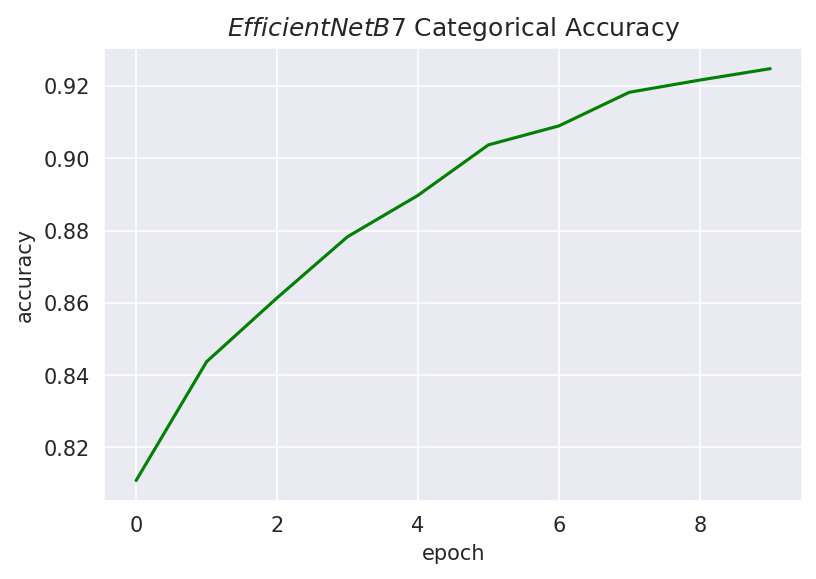

time: 3.67 s (started: 2021-11-12 08:36:52 +00:00)


In [118]:
# Summarizing the history for Accuracy
metric = 'accuracy'

plt.figure(dpi=150)
plt.plot(history.history[metric], 'g')
plt.title(f'$EfficientNetB7$ Categorical Accuracy')

plt.ylabel(metric)
plt.xlabel('epoch')
if not os.path.exists('charts'):
    os.makedirs('charts')

plt.savefig(f"charts/Categorical Accuracy.jpeg")
plt.show()

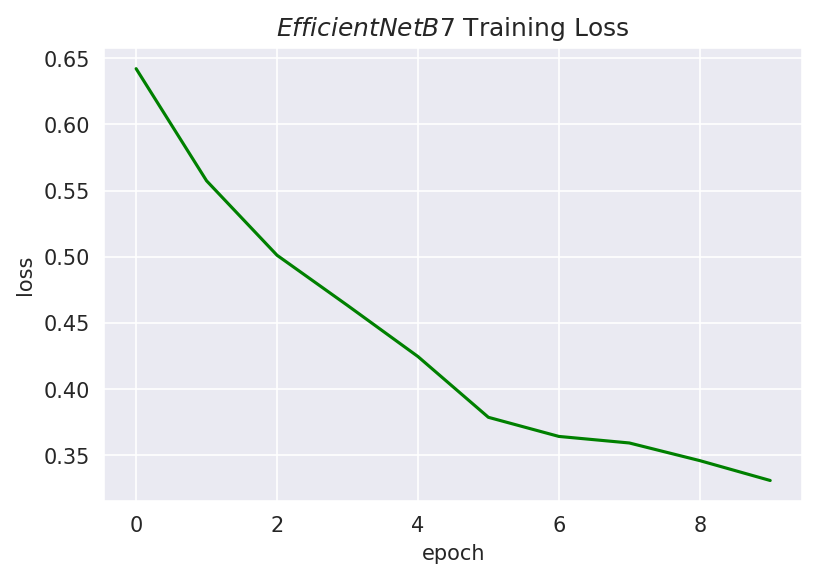

time: 416 ms (started: 2021-11-12 08:36:56 +00:00)


In [119]:
# Summarizing the history for Loss

plt.figure(dpi=150)
plt.plot(history.history['loss'], 'g')
plt.title('$EfficientNetB7$ Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
if not os.path.exists('charts'):
    os.makedirs('charts')

plt.savefig("charts/history_loss.jpeg")
plt.show()

### History for Categorical Accuracy

In [120]:
history.history

{'accuracy': [0.8108715415000916,
  0.8437215685844421,
  0.8613771200180054,
  0.878283679485321,
  0.8897330164909363,
  0.9036969542503357,
  0.9089401364326477,
  0.9182494282722473,
  0.9216200113296509,
  0.9247766137123108],
 'loss': [0.6420667171478271,
  0.5573734045028687,
  0.5011404156684875,
  0.4632469415664673,
  0.42463359236717224,
  0.37872734665870667,
  0.36428946256637573,
  0.35934463143348694,
  0.34602028131484985,
  0.33100229501724243],
 'top_5_accuracy': [0.9777967929840088,
  0.9835749864578247,
  0.9886576533317566,
  0.990904688835144,
  0.9931517839431763,
  0.9953453540802002,
  0.9957733750343323,
  0.9950778484344482,
  0.9968433976173401,
  0.9974853992462158],
 'val_accuracy': [0.84871506690979,
  0.8571197390556335,
  0.8706966042518616,
  0.8854048848152161,
  0.8797478675842285,
  0.8863746523857117,
  0.891142725944519,
  0.8963956832885742,
  0.8929206132888794,
  0.8964765071868896],
 'val_loss': [0.5202950239181519,
  0.5157673954963684,
  0.5

time: 3.89 ms (started: 2021-11-12 08:36:56 +00:00)


### Prediction and Output Generator

In [121]:
## Import Test-Folder and predict each values:
directory = 'test'

time: 970 µs (started: 2021-11-12 08:36:56 +00:00)


In [122]:
print(tf.__version__)

2.7.0
time: 933 µs (started: 2021-11-12 08:36:56 +00:00)


In [145]:
test_set = tf.keras.utils.image_dataset_from_directory('test',
                                                   labels=None,image_size=(600,600),shuffle=False)

Found 4315 files belonging to 1 classes.
time: 234 ms (started: 2021-11-12 08:50:47 +00:00)


In [146]:
#test_set = tf.keras.preprocessing.image_dataset_from_directory(
#    directory, shuffle= False, batch_size = 32, image_size=(600, 600))

time: 865 µs (started: 2021-11-12 08:50:48 +00:00)


In [147]:
for x in test_set.file_paths:
    print(x)

test/test/1.jpg
test/test/10.jpg
test/test/100.jpg
test/test/1000.jpg
test/test/1001.jpg
test/test/1002.jpg
test/test/1003.jpg
test/test/1004.jpg
test/test/1005.jpg
test/test/1006.jpg
test/test/1007.jpg
test/test/1008.jpg
test/test/1009.jpg
test/test/101.jpg
test/test/1010.jpg
test/test/1011.jpg
test/test/1012.jpg
test/test/1013.jpg
test/test/1014.jpg
test/test/1015.jpg
test/test/1016.jpg
test/test/1017.jpg
test/test/1018.jpg
test/test/1019.jpg
test/test/102.jpg
test/test/1020.jpg
test/test/1021.jpg
test/test/1022.jpg
test/test/1023.jpg
test/test/1024.jpg
test/test/1025.jpg
test/test/1026.jpg
test/test/1027.jpg
test/test/1028.jpg
test/test/1029.jpg
test/test/103.jpg
test/test/1030.jpg
test/test/1031.jpg
test/test/1032.jpg
test/test/1033.jpg
test/test/1034.jpg
test/test/1035.jpg
test/test/1036.jpg
test/test/1037.jpg
test/test/1038.jpg
test/test/1039.jpg
test/test/104.jpg
test/test/1040.jpg
test/test/1041.jpg
test/test/1042.jpg
test/test/1043.jpg
test/test/1044.jpg
test/test/1045.jpg
tes

In [140]:
import pandas as pd
df = pd.DataFrame([int(x.replace('test/','').replace('.jpg','')) for x in test_set.file_paths])
df

,0
0,1
1,10
2,100
3,1000
4,1001
...,...
4310,995
4311,996
4312,997
4313,998


time: 16.8 ms (started: 2021-11-12 08:46:11 +00:00)


In [141]:
pred_test = model.predict(test_set)

time: 1min 50s (started: 2021-11-12 08:46:11 +00:00)


In [ ]:
test_df = pd.DataFrame()

In [ ]:
test_df['Id'] = [int(x.replace('test/','').replace('.jpg','')) for x in test_set.file_paths]

In [ ]:
import pandas as pd
mapper = pd.DataFrame()
mapper['range']=[str(x) for x in range(75)]
mapper.sort_values(by='range',inplace=True)
mapper.reset_index(drop=True,inplace=True)
mapper.reset_index(inplace=True)
mapping_dict = {k:int(v) for k,v in zip(mapper['index'],mapper['range'])}


In [142]:
output = [mapping_dict[x] for x in mapping_dict]

time: 1.01 ms (started: 2021-11-12 08:48:02 +00:00)


# Elearn-Export:

In [143]:
#test_df = pd.DataFrame()
#test_df['Id'] = [int(x.replace('#directory of the test dataset','').replace('.jpg','')) for x in test_ds.file_paths]
top_5 = pred_test.argsort(axis=-1)[:,-5:]
test_df[[5-i for i in range(5)]] = top_5
for i in range(1,6):
  test_df[i] = [mapping_dict[x] for x in test_df[i]]
test_df.sort_values(by='Id',inplace=True)
test_df.reset_index(drop=True,inplace=True)
test_df
test_df = test_df[['Id',1,2,3,4,5]]
test_df.columns = ['Id','Top 1','Top 2','Top 3','Top 4','Top 5']
test_df['Top 5'] = test_df[test_df.columns[1:]].apply(lambda x: ','.join(x.astype(str)),axis=1)
test_df[['Id','Top 1','Top 5']].to_csv('submission_final.csv',index=False)

time: 347 ms (started: 2021-11-12 08:48:02 +00:00)


# Kaggle Export

In [148]:
test_df = pd.DataFrame()
test_df['Id'] = [int(x.replace('test/','').replace('.jpg','')) for x in test_set.file_paths]
test_df['Top 1'] = pred_test.argmax(axis=-1)
test_df['Top 1'] = [mapping_dict[x] for x in test_df['Top 1']]
test_df.sort_values(by='Id').to_csv('submission_kaggle.csv',index=False)


time: 25.1 ms (started: 2021-11-12 08:50:58 +00:00)


time: 8.14 ms (started: 2021-11-12 03:42:14 +00:00)


In [ ]:
## Given that the test-set is ordered we can test the approximate value of the kaggle-submission

In [136]:
from sklearn.metrics import accuracy_score,classification_report
from scipy.stats import mode

def test_accuracy(input_ordered_pred):
    ## Returns the approximate accuracy on the test set. The better your model is, the more accurate the results will be
    def find_true_labels(input_pred,window=3):
      
        ## Input vector of predictions and outputs the true labels (approximate)
        padded = [0]*window+list(input_pred)+[0]*window
        true = []
        for i in range(len(input_pred)):
            true.append(mode(padded[i:i+(window*2)+1]).mode[0])
        return true
    true = find_true_labels(find_true_labels(input_ordered_pred))
    return accuracy_score(true,input_ordered_pred),classification_report(true,input_ordered_pred)

test_acc, crep = test_accuracy(test_df['Top 1'])
print('Accuracy: ',test_acc)
print(crep)


Accuracy:  0.8368482039397451
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        55
           1       0.85      0.95      0.90       105
           2       0.71      0.88      0.79       123
           3       0.98      0.80      0.88       124
           4       0.79      0.94      0.85        94
           5       0.90      0.79      0.84       103
           6       0.83      0.72      0.77       123
           7       0.92      0.81      0.86        81
           8       0.90      0.87      0.88        53
           9       0.98      0.94      0.96       101
          10       0.81      0.90      0.85        52
          11       0.92      0.84      0.88        77
          12       0.94      0.97      0.96        67
          13       0.94      0.73      0.82       101
          14       0.38      0.56      0.45         9
          15       0.92      0.96      0.94        51
          16       0.58      0.77      0.66        